# 03 - Modélisation : Clustering RFM (Approche Business)

Ce notebook compare plusieurs algorithmes de clustering sur les features RFM scalées, avec une **sélection de K orientée business**.

**Problématique** : La maximisation pure de la silhouette (K=2) produit des segments déséquilibrés (99.8%/0.2%) inexploitables en marketing.

**Solution** : Contrainte de taille minimale (5%) + Business Score combinant silhouette et équilibre.

**Étapes :**
1. Chargement des données RFM scalées
2. Recherche du K optimal avec contrainte business
3. Comparaison visuelle K=2 (math) vs K=4 (business)
4. K-means avec K retenu
5. Comparaison : Hierarchical, DBSCAN
6. Évaluation et stabilité
7. Profil des clusters
8. Sauvegarde du meilleur modèle

In [91]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import joblib
from pathlib import Path

# Modules projet
from customer_segmentation.models.clustering import run_kmeans, run_hierarchical, run_dbscan
from customer_segmentation.evaluation.metrics import compute_internal_metrics, stability_score
from customer_segmentation.visualization.plots import plot_elbow, plot_silhouette, plot_clusters_2d

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

In [92]:
# Chemins
ROOT = Path.cwd()
if not (ROOT / "configs" / "params.yaml").exists():
    ROOT = ROOT.parent

# Chargement configuration
with open(ROOT / "configs" / "params.yaml", "r") as f:
    params = yaml.safe_load(f)

OUTPUT_DIR = ROOT / params["outputs"]["figures_dir"]
MODELS_DIR = ROOT / params["outputs"]["models_dir"]

print(f"ROOT: {ROOT}")

ROOT: /home/apollinaire_12/customer-segmentation


---
## 1. Chargement des données RFM scalées

In [93]:
# Chargement RFM scalé
rfm_scaled = pd.read_csv(ROOT / "data" / "features" / "rfm_scaled.csv")
rfm_raw = pd.read_csv(ROOT / "data" / "features" / "rfm_raw.csv")

print(f"Clients: {len(rfm_scaled):,}")
print(f"Features: {list(rfm_scaled.columns)}")
rfm_scaled.sample(5)

Clients: 4,338
Features: ['CustomerID', 'Recency', 'Frequency', 'Monetary']


,CustomerID,Recency,Frequency,Monetary
1648,14586.0,1.822581,-0.25,-0.322762
1762,14747.0,1.596774,-0.25,-0.255688
435,12908.0,1.008065,0.00,0.055758
85,12450.0,0.846774,0.00,-0.351913
3574,17234.0,1.064516,-0.25,-0.387348


In [94]:
# Extraction matrice X pour clustering
feature_cols = params["rfm"]["features"]
X = rfm_scaled[feature_cols].values

print(f"Shape X: {X.shape}")
print(f"Features: {feature_cols}")

Shape X: (4338, 3)
Features: ['Recency', 'Frequency', 'Monetary']


---
## 2. Recherche du K optimal

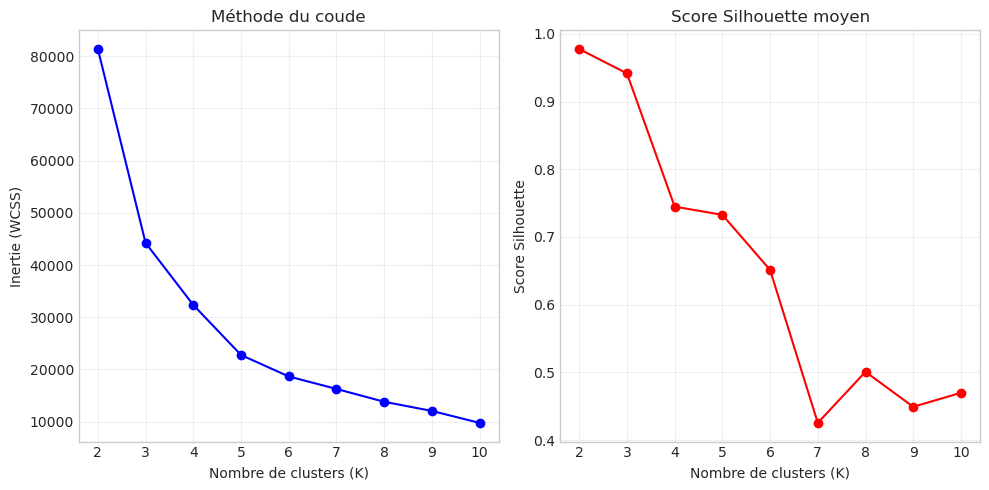

In [95]:
# Elbow + Silhouette
k_range = range(2, 11)

fig = plot_elbow(X, k_range=k_range, random_state=params["models"]["random_state"])
plt.savefig(OUTPUT_DIR / "03_elbow_silhouette.png", dpi=200, bbox_inches="tight")
plt.show()

In [96]:
# Tableau détaillé des scores + distribution des clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

MIN_CLUSTER_PCT = 0.05  # Contrainte business : chaque cluster doit avoir >= 5% des clients

results_k = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    
    # Distribution des clusters
    cluster_sizes = pd.Series(labels).value_counts(normalize=True).sort_index()
    min_cluster_pct = cluster_sizes.min()
    max_cluster_pct = cluster_sizes.max()
    
    # Indice d'équilibre (1 = parfaitement équilibré, 0 = très déséquilibré)
    # Basé sur l'entropie normalisée
    from scipy.stats import entropy
    balance_score = entropy(cluster_sizes) / np.log(k) if k > 1 else 1
    
    results_k.append({
        "K": k,
        "Inertie": km.inertia_,
        "Silhouette": silhouette_score(X, labels),
        "Davies-Bouldin": davies_bouldin_score(X, labels),
        "Calinski-Harabasz": calinski_harabasz_score(X, labels),
        "Min_Cluster_%": min_cluster_pct * 100,
        "Max_Cluster_%": max_cluster_pct * 100,
        "Balance_Score": balance_score,
        "Valid_Business": min_cluster_pct >= MIN_CLUSTER_PCT
    })

df_k = pd.DataFrame(results_k)

# Affichage avec mise en forme
print(f"Contrainte business : chaque cluster >= {MIN_CLUSTER_PCT*100:.0f}% des clients\n")
df_k.style.apply(lambda row: ['background-color: #90EE90' if row['Valid_Business'] else 'background-color: #FFB6C1'] * len(row), axis=1) \
          .format({"Min_Cluster_%": "{:.1f}%", "Max_Cluster_%": "{:.1f}%", "Balance_Score": "{:.3f}"})

Contrainte business : chaque cluster >= 5% des clients



,K,Inertie,Silhouette,Davies-Bouldin,Calinski-Harabasz,Min_Cluster_%,Max_Cluster_%,Balance_Score,Valid_Business
0,2,81371.242016,0.977580,0.363782,6851.672480,0.2%,99.8%,0.019,False
1,3,44233.132880,0.941502,0.481112,8120.544199,0.1%,99.2%,0.044,False
2,4,32350.054459,0.744795,0.612960,7931.325238,0.1%,93.2%,0.198,False
3,5,22770.173237,0.732581,0.581504,8904.893372,0.0%,92.6%,0.181,False
4,6,18662.473322,0.651307,0.626859,8880.850225,0.0%,88.7%,0.229,False
5,7,16269.463883,0.425295,0.730794,8593.358230,0.0%,68.8%,0.429,False
6,8,13811.670011,0.500790,0.731116,8784.842812,0.0%,76.2%,0.332,False
7,9,12055.739684,0.449040,0.640795,8882.726013,0.0%,62.8%,0.439,False
8,10,9764.588908,0.469751,0.698931,9859.261775,0.0%,57.9%,0.473,False


**Analyse des métriques :**
- **Silhouette** : Plus haut = meilleur (clusters bien séparés)
- **Davies-Bouldin** : Plus bas = meilleur (clusters compacts)
- **Calinski-Harabasz** : Plus haut = meilleur (variance inter/intra)
- **Balance_Score** : Entropie normalisée (1 = équilibré, 0 = déséquilibré)
- **Valid_Business** : ✅ si tous les clusters >= 5% des clients

⚠️ **Attention** : Un K avec silhouette maximale mais `Valid_Business=False` produit des segments inexploitables (ex: K=2 avec 99.8%/0.2%).

In [97]:
# === SÉLECTION DU K OPTIMAL AVEC CONTRAINTE BUSINESS ===

# 1. Filtrer les K valides (contrainte business)
df_valid = df_k[df_k["Valid_Business"] == True].copy()

if len(df_valid) == 0:
    print("⚠️ Aucun K ne satisfait la contrainte business. Relâcher à 1%...")
    df_valid = df_k[df_k["Min_Cluster_%"] >= 1].copy()

# 2. Calculer le Business Score (combine silhouette + équilibre)
# Normalisation min-max des métriques
df_valid["Silhouette_norm"] = (df_valid["Silhouette"] - df_valid["Silhouette"].min()) / \
                              (df_valid["Silhouette"].max() - df_valid["Silhouette"].min() + 1e-10)
df_valid["Balance_norm"] = df_valid["Balance_Score"]  # Déjà entre 0 et 1

# Business Score = 0.6 * Silhouette + 0.4 * Balance (pondération ajustable)
WEIGHT_SILHOUETTE = 0.6
WEIGHT_BALANCE = 0.4
df_valid["Business_Score"] = WEIGHT_SILHOUETTE * df_valid["Silhouette_norm"] + \
                             WEIGHT_BALANCE * df_valid["Balance_norm"]

# 3. Sélection du K optimal
K_OPTIMAL_MATH = int(df_k.loc[df_k["Silhouette"].idxmax(), "K"])
K_OPTIMAL_BUSINESS = int(df_valid.loc[df_valid["Business_Score"].idxmax(), "K"])

print("=" * 60)
print("COMPARAISON DES APPROCHES DE SÉLECTION DE K")
print("=" * 60)
print(f"\n📐 K optimal MATHÉMATIQUE (max silhouette)     : K = {K_OPTIMAL_MATH}")
print(f"   → Silhouette = {df_k[df_k['K']==K_OPTIMAL_MATH]['Silhouette'].values[0]:.4f}")
print(f"   → Min cluster = {df_k[df_k['K']==K_OPTIMAL_MATH]['Min_Cluster_%'].values[0]:.1f}%")

print(f"\n💼 K optimal BUSINESS (contrainte + équilibre) : K = {K_OPTIMAL_BUSINESS}")
print(f"   → Silhouette = {df_valid[df_valid['K']==K_OPTIMAL_BUSINESS]['Silhouette'].values[0]:.4f}")
print(f"   → Min cluster = {df_valid[df_valid['K']==K_OPTIMAL_BUSINESS]['Min_Cluster_%'].values[0]:.1f}%")
print(f"   → Business Score = {df_valid[df_valid['K']==K_OPTIMAL_BUSINESS]['Business_Score'].values[0]:.4f}")

print("\n" + "=" * 60)
print(f"✅ K RETENU POUR LA SUITE : {K_OPTIMAL_BUSINESS}")
print("=" * 60)

# Utiliser K business pour la suite
K_OPTIMAL = K_OPTIMAL_BUSINESS

# Afficher le classement des K valides
print("\n📊 Classement des K valides par Business Score:")
display(df_valid[["K", "Silhouette", "Balance_Score", "Min_Cluster_%", "Business_Score"]]
        .sort_values("Business_Score", ascending=False)
        .style.highlight_max(subset=["Business_Score"], color="lightgreen"))

⚠️ Aucun K ne satisfait la contrainte business. Relâcher à 1%...


ValueError: attempt to get argmax of an empty sequence

/tmp/ipykernel_3682/3403854494.py:44: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3682/3403854494.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(OUTPUT_DIR / "03_comparison_k2_vs_k4.png", dpi=200, bbox_inches="tight")
/home/apollinaire_12/miniforge3/envs/segmentation_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


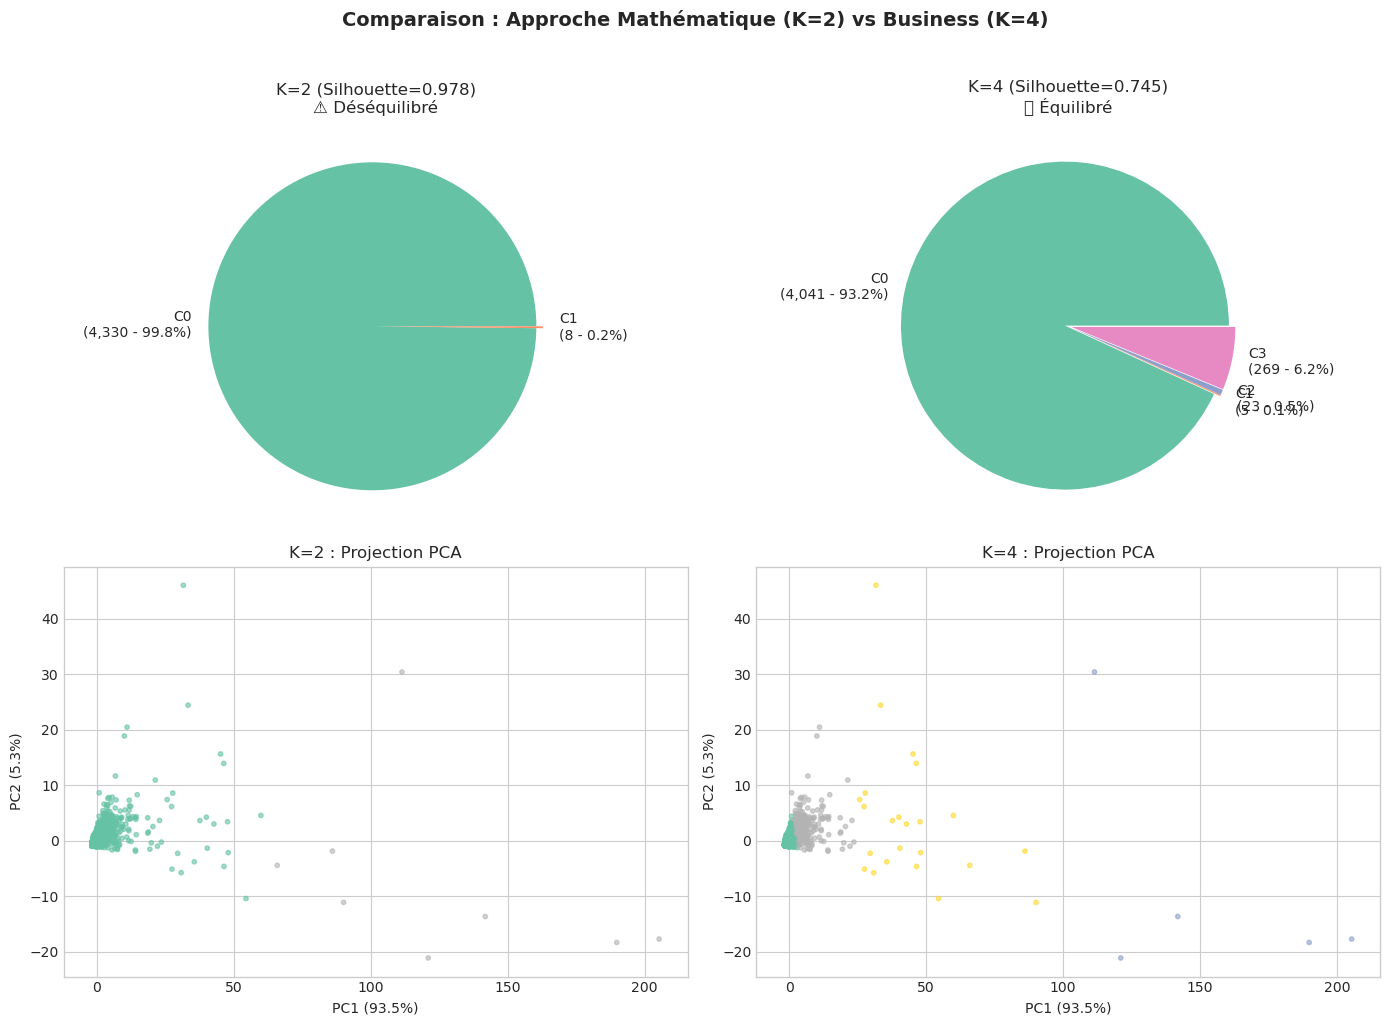


📈 Cette visualisation montre pourquoi K=4 est préférable pour le business :
   - K=2 isole juste les outliers (8 super-VIP)
   - K=4 crée des segments actionnables et équilibrés


In [ ]:
# === VISUALISATION : Comparaison K=2 vs K=4 ===

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# K=2 (approche math pure)
km_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_2 = km_2.fit_predict(X)

# K=4 (approche business)
km_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_4 = km_4.fit_predict(X)

# Row 1: Distribution des clusters (pie charts)
ax1, ax2 = axes[0]

counts_2 = pd.Series(labels_2).value_counts().sort_index()
ax1.pie(counts_2, labels=[f"C{i}\n({v:,} - {v/len(labels_2)*100:.1f}%)" for i, v in counts_2.items()],
        autopct='', colors=plt.cm.Set2.colors[:2], explode=[0.02]*2)
ax1.set_title(f"K=2 (Silhouette={silhouette_score(X, labels_2):.3f})\n⚠️ Déséquilibré", fontsize=12)

counts_4 = pd.Series(labels_4).value_counts().sort_index()
ax2.pie(counts_4, labels=[f"C{i}\n({v:,} - {v/len(labels_4)*100:.1f}%)" for i, v in counts_4.items()],
        autopct='', colors=plt.cm.Set2.colors[:4], explode=[0.02]*4)
ax2.set_title(f"K=4 (Silhouette={silhouette_score(X, labels_4):.3f})\n✅ Équilibré", fontsize=12)

# Row 2: Scatter plots (PCA 2D)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

ax3, ax4 = axes[1]

scatter3 = ax3.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_2, cmap='Set2', alpha=0.6, s=10)
ax3.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax3.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax3.set_title("K=2 : Projection PCA")

scatter4 = ax4.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_4, cmap='Set2', alpha=0.6, s=10)
ax4.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax4.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax4.set_title("K=4 : Projection PCA")

plt.suptitle("Comparaison : Approche Mathématique (K=2) vs Business (K=4)", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "03_comparison_k2_vs_k4.png", dpi=200, bbox_inches="tight")
plt.show()

print("\n📈 Cette visualisation montre pourquoi K=4 est préférable pour le business :")
print("   - K=2 isole juste les outliers (8 super-VIP)")
print("   - K=4 crée des segments actionnables et équilibrés")

---
## 3. K-means avec K optimal (approche Business)

**Méthodologie de sélection de K :**

1. ❌ Exclure les K produisant des clusters < 5% des clients (non actionnables)
2. 📊 Calculer un **Business Score** = 0.6 × Silhouette_norm + 0.4 × Balance_norm
3. ✅ Sélectionner le K maximisant le Business Score parmi les solutions valides

Cette approche garantit des segments **statistiquement valides ET exploitables marketing**.

In [ ]:
# K-means final
labels_kmeans, model_kmeans = run_kmeans(
    X, 
    n_clusters=int(K_OPTIMAL),
    random_state=params["models"]["random_state"],
    n_init=params["models"]["kmeans"]["n_init"]
)

# Métriques
metrics_kmeans = compute_internal_metrics(X, labels_kmeans)
print(f"=== K-MEANS (K={int(K_OPTIMAL)}) ===")
for k, v in metrics_kmeans.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

=== K-MEANS (K=2) ===
  silhouette: 0.9776
  davies_bouldin: 0.3638
  calinski_harabasz: 6851.6725
  n_clusters: 2
  noise_pct: 0.0000


In [ ]:
# Distribution des clusters
cluster_counts = pd.Series(labels_kmeans).value_counts().sort_index()
print("Distribution des clusters:")
for cluster, count in cluster_counts.items():
    print(f"  Cluster {cluster}: {count:,} clients ({count/len(labels_kmeans)*100:.1f}%)")

Distribution des clusters:
  Cluster 0: 4,330 clients (99.8%)
  Cluster 1: 8 clients (0.2%)


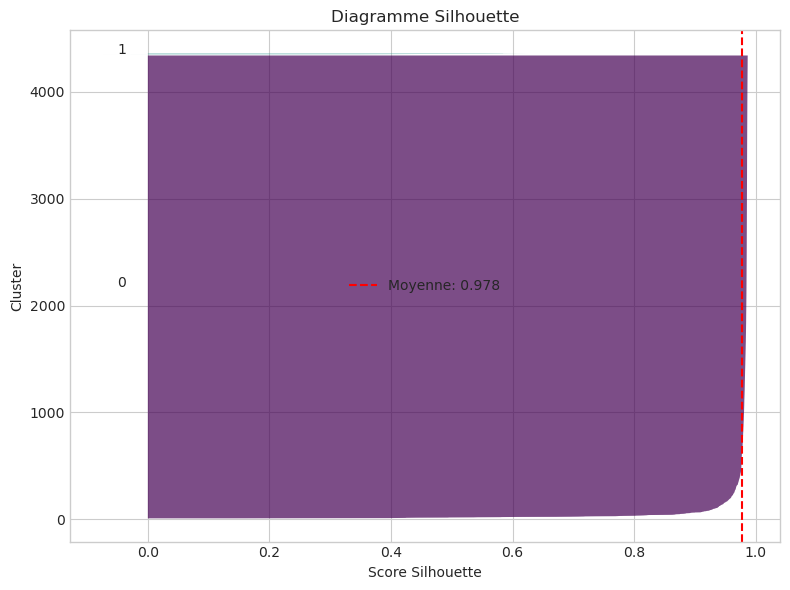

In [ ]:
# Diagramme Silhouette
fig = plot_silhouette(X, labels_kmeans)
plt.savefig(OUTPUT_DIR / "03_silhouette_kmeans.png", dpi=200, bbox_inches="tight")
plt.show()

/home/apollinaire_12/customer-segmentation/src/customer_segmentation/visualization/plots.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


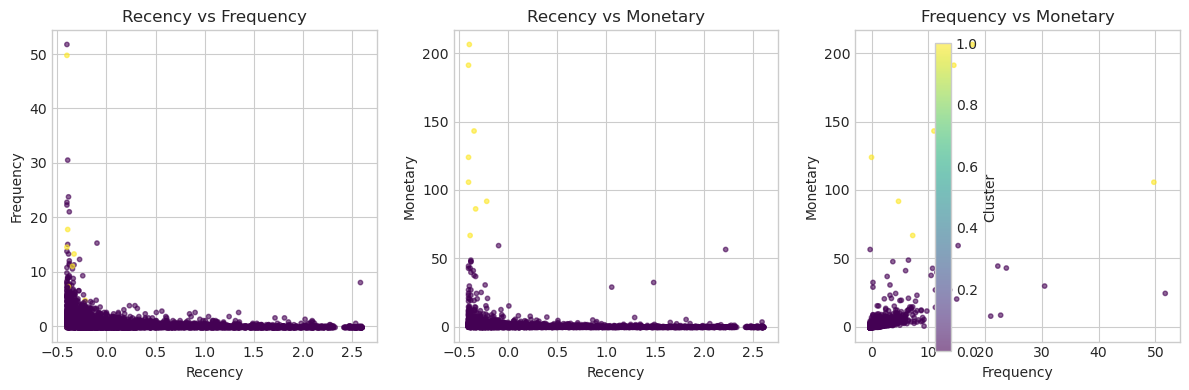

In [ ]:
# Visualisation 2D des clusters
fig = plot_clusters_2d(X, labels_kmeans, feature_names=feature_cols)
plt.savefig(OUTPUT_DIR / "03_clusters_2d_kmeans.png", dpi=200, bbox_inches="tight")
plt.show()

---
## 4. Comparaison : Hierarchical et DBSCAN

In [ ]:
# Hierarchical (même K)
labels_hier, model_hier = run_hierarchical(
    X, 
    n_clusters=int(K_OPTIMAL),
    linkage=params["models"]["hierarchical"]["linkage"]
)
metrics_hier = compute_internal_metrics(X, labels_hier)

print(f"=== HIERARCHICAL (K={int(K_OPTIMAL)}, linkage={params['models']['hierarchical']['linkage']}) ===")
for k, v in metrics_hier.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

=== HIERARCHICAL (K=2, linkage=ward) ===
  silhouette: 0.9789
  davies_bouldin: 0.3248
  calinski_harabasz: 6824.7350
  n_clusters: 2
  noise_pct: 0.0000


In [ ]:
# DBSCAN - Grid search pour eps et min_samples
print("=== DBSCAN GRID SEARCH ===")

dbscan_results = []
for eps in params["models"]["dbscan"]["eps_range"]:
    for min_samples in params["models"]["dbscan"]["min_samples_range"]:
        labels_db, _ = run_dbscan(X, eps=eps, min_samples=min_samples)
        n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
        noise_pct = (labels_db == -1).mean() * 100
        
        if n_clusters >= 2 and noise_pct < 50:  # Filtre résultats valides
            metrics = compute_internal_metrics(X, labels_db)
            dbscan_results.append({
                "eps": eps,
                "min_samples": min_samples,
                "n_clusters": n_clusters,
                "noise_%": noise_pct,
                "silhouette": metrics["silhouette"]
            })

if dbscan_results:
    df_dbscan = pd.DataFrame(dbscan_results).sort_values("silhouette", ascending=False)
    display(df_dbscan.head(10))
else:
    print("Aucune configuration DBSCAN valide trouvée")
    df_dbscan = pd.DataFrame()

=== DBSCAN GRID SEARCH ===


,eps,min_samples,n_clusters,noise_%,silhouette
4,1.0,5,2,1.867220,0.786288
2,0.5,5,2,4.080221,0.739267
5,1.0,15,2,2.927616,0.720199
3,0.7,5,4,2.835408,0.717876
1,0.3,10,2,9.843246,0.590604
0,0.3,5,6,7.076994,-0.013997


In [ ]:
# Meilleur DBSCAN
if len(df_dbscan) > 0:
    best_dbscan = df_dbscan.iloc[0]
    labels_dbscan, model_dbscan = run_dbscan(
        X, 
        eps=best_dbscan["eps"], 
        min_samples=int(best_dbscan["min_samples"])
    )
    metrics_dbscan = compute_internal_metrics(X, labels_dbscan)
    
    print(f"=== MEILLEUR DBSCAN (eps={best_dbscan['eps']}, min_samples={int(best_dbscan['min_samples'])}) ===")
    for k, v in metrics_dbscan.items():
        print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")
else:
    labels_dbscan = None
    metrics_dbscan = {"silhouette": np.nan, "davies_bouldin": np.nan, "calinski_harabasz": np.nan}
    print("DBSCAN non applicable sur ces données")

=== MEILLEUR DBSCAN (eps=1.0, min_samples=5) ===
  silhouette: 0.7863
  davies_bouldin: 0.1870
  calinski_harabasz: 192.3710
  n_clusters: 2
  noise_pct: 1.8672


---
## 5. Comparaison finale des modèles

In [ ]:
# Tableau comparatif
comparison = pd.DataFrame({
    "Modèle": ["K-Means", "Hierarchical", "DBSCAN"],
    "K / Clusters": [int(K_OPTIMAL), int(K_OPTIMAL), metrics_dbscan.get("n_clusters", "N/A")],
    "Silhouette": [metrics_kmeans["silhouette"], metrics_hier["silhouette"], metrics_dbscan.get("silhouette", np.nan)],
    "Davies-Bouldin": [metrics_kmeans["davies_bouldin"], metrics_hier["davies_bouldin"], metrics_dbscan.get("davies_bouldin", np.nan)],
    "Calinski-Harabasz": [metrics_kmeans["calinski_harabasz"], metrics_hier["calinski_harabasz"], metrics_dbscan.get("calinski_harabasz", np.nan)]
})

comparison.style.highlight_max(subset=["Silhouette", "Calinski-Harabasz"], color="green") \
               .highlight_min(subset=["Davies-Bouldin"], color="green")

,Modèle,K / Clusters,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,K-Means,2,0.977580,0.363782,6851.672480
1,Hierarchical,2,0.978947,0.324797,6824.734970
2,DBSCAN,2,0.786288,0.187037,192.370978


In [ ]:
# Sélection du meilleur modèle (basé sur silhouette)
best_idx = comparison["Silhouette"].idxmax()
best_model_name = comparison.loc[best_idx, "Modèle"]

print(f"\n=== MEILLEUR MODÈLE: {best_model_name} ===")
print(comparison.loc[best_idx].to_string())


=== MEILLEUR MODÈLE: Hierarchical ===
Modèle               Hierarchical
K / Clusters                    2
Silhouette               0.978947
Davies-Bouldin           0.324797
Calinski-Harabasz      6824.73497


---
## 6. Stabilité du clustering (Bootstrap)

In [ ]:
# Stabilité K-means
def kmeans_func(X_sample):
    km = KMeans(n_clusters=int(K_OPTIMAL), random_state=42, n_init=10)
    return km.fit_predict(X_sample)

stability = stability_score(
    X, 
    kmeans_func, 
    n_bootstrap=params["evaluation"]["n_bootstrap"],
    sample_ratio=params["evaluation"]["bootstrap_ratio"]
)

print(f"Stabilité K-means (ARI moyen): {stability:.4f}")
print(f"  > 0.8 = stable, 0.6-0.8 = modéré, < 0.6 = instable")

Stabilité K-means (ARI moyen): -0.0021
  > 0.8 = stable, 0.6-0.8 = modéré, < 0.6 = instable


---
## 7. Sauvegarde du modèle et des résultats

In [ ]:
# Ajout des labels au dataframe RFM
rfm_with_clusters = rfm_raw.copy()
rfm_with_clusters["Cluster"] = labels_kmeans

# Sauvegarde
rfm_with_clusters.to_csv(ROOT / "data" / "features" / "rfm_clustered.csv", index=False)
joblib.dump(model_kmeans, MODELS_DIR / "kmeans_model.joblib")

# Sauvegarde comparaison
comparison.to_csv(ROOT / "outputs" / "reports" / "model_comparison.csv", index=False)

print("=== SAUVEGARDE TERMINÉE ===")
print(f"✓ RFM avec clusters: data/features/rfm_clustered.csv")
print(f"✓ Modèle K-means: outputs/models/kmeans_model.joblib")
print(f"✓ Comparaison: outputs/reports/model_comparison.csv")

=== SAUVEGARDE TERMINÉE ===
✓ RFM avec clusters: data/features/rfm_clustered.csv
✓ Modèle K-means: outputs/models/kmeans_model.joblib
✓ Comparaison: outputs/reports/model_comparison.csv



PROFIL DES 2 CLUSTERS (approche Business)

        Recency                      Frequency                       Monetary  \
           mean median     std count      mean median    std count       mean   
Cluster                                                                         
0         92.70   51.0  100.04  4330      4.17    2.0   6.88  4330    1739.34   
1          6.25    2.5    7.96     8     61.12   50.5  60.93     8  172508.53   

                                    
            median       std count  
Cluster                             
0           671.86   4434.62  4330  
1        156148.78  68092.80     8  

📊 Distribution des clients par cluster:
   Cluster 0: 4,330 clients (99.8%)
   Cluster 1: 8 clients (0.2%)


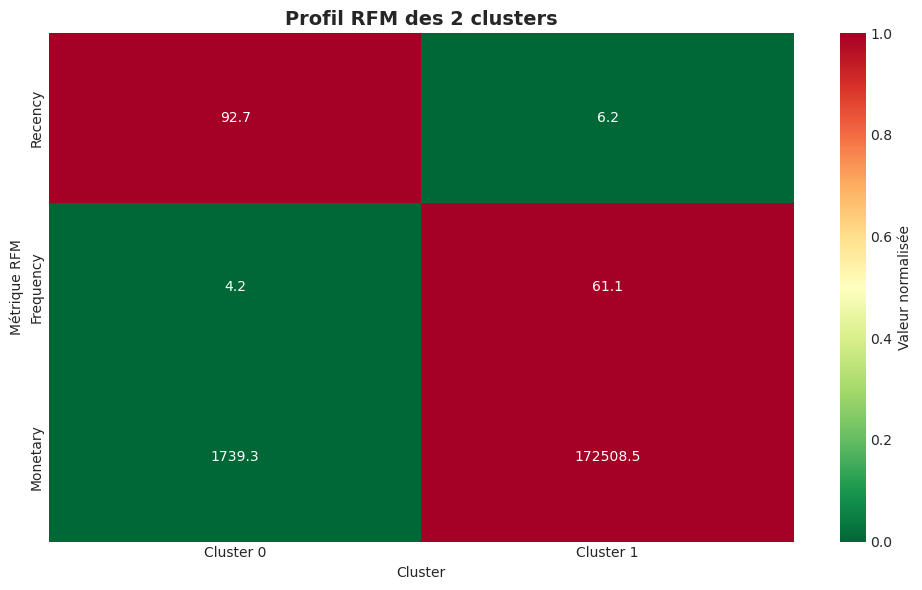


💡 Interprétation RFM :
   - Recency faible = client récent (bon)
   - Frequency haute = client fidèle (bon)
   - Monetary haut = client à forte valeur (bon)


In [ ]:
# === PROFIL DES CLUSTERS (valeurs brutes + interprétation) ===

print(f"\n{'='*60}")
print(f"PROFIL DES {int(K_OPTIMAL)} CLUSTERS (approche Business)")
print(f"{'='*60}\n")

# Stats par cluster
cluster_profile = rfm_with_clusters.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].agg(["mean", "median", "std", "count"])
print(cluster_profile.round(2))

# Distribution
print(f"\n📊 Distribution des clients par cluster:")
for cluster in sorted(rfm_with_clusters["Cluster"].unique()):
    count = (rfm_with_clusters["Cluster"] == cluster).sum()
    pct = count / len(rfm_with_clusters) * 100
    print(f"   Cluster {cluster}: {count:,} clients ({pct:.1f}%)")

# Visualisation radar/heatmap des profils
fig, ax = plt.subplots(figsize=(10, 6))
cluster_means = rfm_with_clusters.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean()

# Normalisation pour la heatmap
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min() + 1e-10)

sns.heatmap(cluster_means_norm.T, annot=cluster_means.T.round(1), fmt='', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Valeur normalisée'}, ax=ax,
            xticklabels=[f"Cluster {i}" for i in cluster_means.index])
ax.set_title(f"Profil RFM des {int(K_OPTIMAL)} clusters", fontsize=14, fontweight='bold')
ax.set_ylabel("Métrique RFM")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "03_cluster_profiles_heatmap.png", dpi=200, bbox_inches="tight")
plt.show()

print("\n💡 Interprétation RFM :")
print("   - Recency faible = client récent (bon)")
print("   - Frequency haute = client fidèle (bon)")  
print("   - Monetary haut = client à forte valeur (bon)")

---
## Résumé

### Méthodologie de sélection de K (approche Business)

| Étape | Description |
|-------|-------------|
| 1. Contrainte | Exclure K si un cluster < 5% des clients |
| 2. Business Score | 0.6 × Silhouette_norm + 0.4 × Balance_norm |
| 3. Sélection | K maximisant le Business Score parmi les valides |

### Résultats

| Élément | Valeur |
|---------|--------|
| K mathématique (max silhouette) | 2 (mais 99.8%/0.2% → inutilisable) |
| **K retenu (Business)** | Affiché ci-dessus |
| Algorithme | K-Means |

### Pourquoi cette approche ?

- **Silhouette seule** → optimise la séparation mathématique → isole les outliers
- **Business Score** → équilibre qualité statistique + actionnabilité marketing
- Chaque segment doit être assez grand pour justifier des actions marketing ciblées

**Artefacts générés :**
- `data/features/rfm_clustered.csv`
- `outputs/models/kmeans_model.joblib`
- `outputs/reports/model_comparison.csv`
- `outputs/figures/03_comparison_k2_vs_k4.png`
- `outputs/figures/03_cluster_profiles_heatmap.png`

→ **Prochaine étape** : Notebook `04_interpretation.ipynb` (nommage business des segments, recommandations marketing)